# 1. Import Hourly Data

In [1]:
#----------- Part-1: Daily Data  ['Date']>'2013-12-31' & ['Date']<'2016-01-01'
#----------- Part-2: Weekly Data  , Monday-Sunday-Sum ,  plot  ,  noise
#----------- Part-3: Polynomial
#----------- Part-4: 

#----------- Other Questions

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, date, timedelta
import warnings
warnings.filterwarnings('ignore')

with open('hourly_data.json','rb') as f:
    data=f.readlines()
hourly_data = json.loads(data[0])

print "import done"

import done


# 2. Create Daily Data

In [13]:
#----------- Part-1: Daily Data


#------- Calculate Daily Count from Hourly Data
dict_sum=lambda one_dict,start,end: dict((str(k),sum(one_dict[k])) for k in one_dict.keys()[start:end])

daily_data=dict_sum(hourly_data,0,len(hourly_data.keys()))


print daily_data.items()[0]

2014-06-30 25981


In [113]:
#----------- Part-1: Daily Data  ['Date']>'2013-12-31' & ['Date']<'2016-01-01'

# Date-Count

raw_data = []
for key,value in daily_data.items():
    raw_data.append((key,value))

data_df = pd.DataFrame(raw_data, columns=['Date','#_of_parking'])


#        Year  Week#  Weekday
# 0      2014     27        1
# Decompose Date to Year, Week# & Weekday
pk_df = pd.DataFrame(map(lambda x: x.isocalendar(), pd.to_datetime(data_df['Date'])), columns=['Year','Week#','Weekday'])

# len(pk_df)=27768
pk_df['Date']=data_df['Date']
pk_df['#_of_parking']=data_df['#_of_parking']
            

# len(use_data_df)=18264
# Based on 'Basic_Static.ipynb: part-7' Ignore data of year 2012 & 2013
# len(use_data_df)=761
use_data_df = pk_df[(pk_df['Date']>'2013-12-31') ]

# len(data_train_new)=730
data_train_new = use_data_df[use_data_df['Date']<'2016-01-01']

# Test data
data_test_new = use_data_df[use_data_df['Date']>='2016-01-01']

print data_train_new.head()

    Year  Week#  Weekday        Date  #_of_parking
0   2014     27        1  2014-06-30         25981
1   2014     42        4  2014-10-16         28203
4   2015     47        4  2015-11-19         28110
12  2015     46        6  2015-11-14          1223
15  2014     42        3  2014-10-15         29487


# 3. Make Weekly Data

In [114]:
#----------- Part-2: Weekly Data： Monday-Sunday-Sum

#  Year  Week#  #_of_parking
#  2014     27   25981

# Test Weekly Data
raw_data=data_train_new.loc[:,['Year','Week#','#_of_parking']]
weekly_data=raw_data.groupby(['Year','Week#']).sum()

# Test Weekly Data
raw_data_test=data_test_new.loc[:,['Year','Week#','#_of_parking']]
weekly_data_test=raw_data_test.groupby(['Year','Week#']).sum()


weekly_data_test.head()

#_of_parking
Year Week#              
2015 53             3088
2016 1            124153
     2            141431
     3            130310
     4            133179

In [51]:
weekly_data.describe()

,#_of_parking
count,105.000000
mean,125421.828571
std,25258.429799
min,27158.000000
25%,123529.000000
50%,132118.000000
75%,140141.000000
max,152588.000000


# 4. Visualize & Outlier

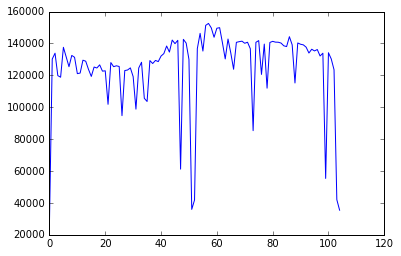

In [54]:
# Plot Weekly Data

w=np.arange(0,105,1)
plt.plot(w,weekly_data['#_of_parking'])

In [70]:
# Outlier
# 1. outlier
# 2. Week & Date of outlier
# 3. Regression      delete->regression->recover

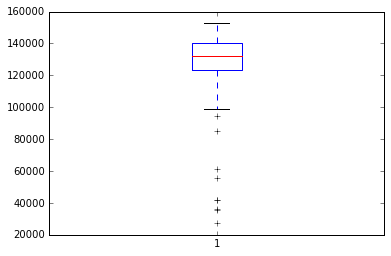

In [61]:
# 1. outlier

r=plt.boxplot(weekly_data['#_of_parking'])
                      
bottom_points = r["fliers"][0].get_data()[1]
# bottom_points = r["fliers"][2].get_data()[1]
                    

In [62]:
bottom_points

array([27158, 94735, 61188, 35945, 41826, 85320, 55360, 42041, 35434])

In [69]:
# 2. Week & Date of outlier

for i in bottom_points:
    print weekly_data[(weekly_data['#_of_parking'] == i)]

            #_of_parking
Year Week#              
2014 1             27158
            #_of_parking
Year Week#              
2014 27            94735
            #_of_parking
Year Week#              
2014 48            61188
            #_of_parking
Year Week#              
2014 52            35945
            #_of_parking
Year Week#              
2015 1             41826
            #_of_parking
Year Week#              
2015 22            85320
            #_of_parking
Year Week#              
2015 48            55360
            #_of_parking
Year Week#              
2015 52            42041
            #_of_parking
Year Week#              
2015 53            35434


# 5. Linear & Robust Linear Regression

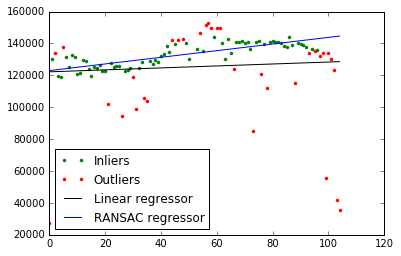

In [160]:
# 3. Regression      
# Robust Regression
#
# http://scikit-learn.org/stable/modules/linear_model.html#robustness-regression-outliers-and-modeling-errors
from sklearn import linear_model

# Train Data
y=weekly_data['#_of_parking'].values
X=np.arange(0,len(y))
X=X.reshape((105,1))

# # Test Data
# y_test=weekly_data_test['#_of_parking'].values
# X_test=np.arange(0,len(y_test))
# X_test=X_test.reshape((len(X_test,1))

# Fit line using all data
model = linear_model.LinearRegression()
model.fit(X, y)


# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(0, 105)
line_y = model.predict(line_X[:, np.newaxis])
line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

# Compare estimated coefficients
# print("Estimated coefficients (true, normal, RANSAC):")
# print(coef, model.coef_, model_ransac.estimator_.coef_)

plt.plot(X[inlier_mask], y[inlier_mask], '.g', label='Inliers')
plt.plot(X[outlier_mask], y[outlier_mask], '.r', label='Outliers')
plt.plot(line_X, line_y, '-k', label='Linear regressor')
plt.plot(line_X, line_y_ransac, '-b', label='RANSAC regressor')
plt.legend(loc='lower left')
plt.show()

# 6. Polynomial + Robust

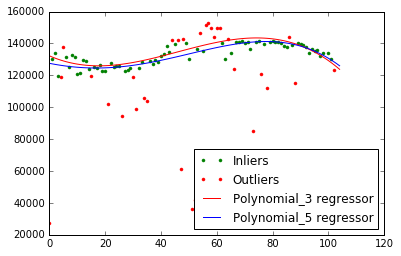

In [124]:
# 3. Regression   OOOOk
# Robust Regression  + polynomial  
# MSE
#
# http://scikit-learn.org/stable/modules/linear_model.html#robustness-regression-outliers-and-modeling-errors
from sklearn import linear_model, metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Train Data
y=weekly_data['#_of_parking'].values
X=np.arange(0,len(y))
X=X.reshape((105,1))
line_X = np.arange(0, 105)


# Test Data
# y_test=weekly_data_test['#_of_parking'].values
# X_test=np.arange(0,len(y_test))
# X_test=X_test.reshape((len(X_test,1))



# Fit line using all data
model = linear_model.LinearRegression()
model.fit(X, y)
# mse_ln = metrics.mean_squared_error(model.predict(X_test), y_test)
line_y = model.predict(line_X[:, np.newaxis])


# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y)
# mse_ransac = metrics.mean_squared_error(model_ransac.predict(X_test), y_test)
line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)


# Polynomial-3
model_poly = make_pipeline(PolynomialFeatures(3),model_ransac )
model_poly.fit(X, y)
# mse_poly = metrics.mean_squared_error(model_poly.predict(X_test), y_test)
line_y_poly = model_poly.predict(line_X[:, np.newaxis])


# Polynomial-5
model_poly_5 = make_pipeline(PolynomialFeatures(5),model_ransac )
model_poly_5.fit(X, y)
# mse_poly_5 = metrics.mean_squared_error(model_poly_5.predict(X_test), y_test)
line_y_poly_5 = model_poly_5.predict(line_X[:, np.newaxis])


# Predict data of estimated models


# Compare estimated coefficients
# print("Estimated coefficients (true, normal, RANSAC):")
# print(coef, model.coef_, model_ransac.estimator_.coef_)

plt.plot(X[inlier_mask], y[inlier_mask], '.g', label='Inliers')
plt.plot(X[outlier_mask], y[outlier_mask], '.r', label='Outliers')
# plt.plot(line_X, line_y, '-k', label='Linear regressor')
# plt.plot(line_X, line_y_ransac, '-b', label='RANSAC regressor')
plt.plot(line_X, line_y_poly, '-r', label='Polynomial_3 regressor')
plt.plot(line_X, line_y_poly_5, '-b', label='Polynomial_5 regressor' )
# plt.plot(line_X, line_y_poly, '-r', label='%s: error = %.3f' % ('Polynomial_3 regressor', mse_poly))
# plt.plot(line_X, line_y_poly_5, '-b', label='%s: error = %.3f' % ('Polynomial_5 regressor', mse_poly_5))
plt.legend(loc='lower right')
plt.show()

In [159]:
mse_ln = metrics.mean_squared_error(line_y, y)
mse_ransac = metrics.mean_squared_error(line_y_ransac, y)
mse_poly = metrics.mean_squared_error(line_y_poly, y)
mse_poly_5 = metrics.mean_squared_error(line_y_poly_5, y)

print 'MSE of Linear Regression: %.3f'%mse_ln
print 'MSE of Robust Linear Regression: %.3f'%mse_ransac
print 'MSE of Polynomial_3 Robust Regression: %.3f'%mse_poly
print 'MSE of Polynomial_5 Robust Regression: %.3f'%mse_poly_5

MSE of Linear Regression: 628450862.424
MSE of Robust Linear Regression: 693034434.456
MSE of Polynomial_3 Robust Regression: 646807385.445
MSE of Polynomial_5 Robust Regression: 624750600.682


In [133]:
# Not work
#
# from sklearn import linear_model, metrics
# mse_ln = metrics.mean_squared_error(model.predict(X_test), y_test)
# line_X_test = np.arange(0, len(y_test))
# model_ransac.predict(line_X_test[:, np.newaxis])

In [163]:
print 'Score of Linear Regression: %.3f'%model.score(X,y)
print 'Score of Robust Linear Regression: %.3f'%model_ransac.score(X,y)
# print 'Score of Polynomial_3 Robust Regression: %.3f'%model_poly.score(X,y)
# print 'Score of Polynomial_5 Robust Regression: %.3f'%model_poly_5.score(X,y)

Score of Linear Regression: 0.005
Score of Robust Linear Regression: -0.138


# 7. MSE Comparation: Polynomial+Linear

Automatically created module for IPython interactive environment


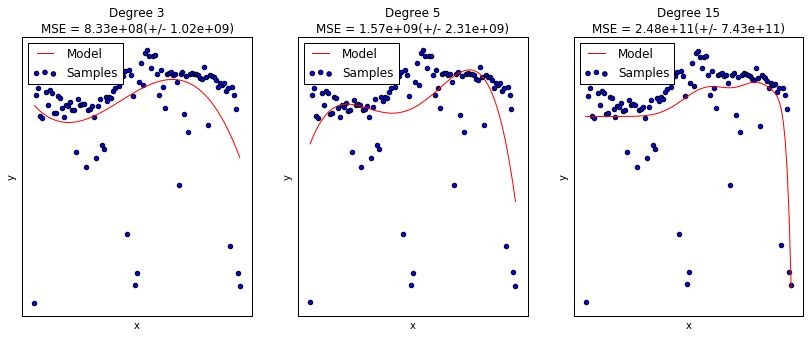

In [165]:
# Just Polynomial

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

# np.random.seed(0)
# n_samples = 30
degrees = [3, 5, 15]

# true_fun = lambda X: np.cos(1.5 * np.pi * X)
# X = np.sort(np.random.rand(n_samples))
# y = true_fun(X) + np.random.randn(n_samples) * 0.1

# Train Data
y=weekly_data['#_of_parking'].values
X=np.arange(0,len(y))
# X=X.reshape((105,1))
# line_X = np.arange(0, 105)


# Test Data
y_test=weekly_data_test['#_of_parking'].values
X_test=np.arange(0,len(y_test))
# X_test=X_test.reshape((len(X_test,1))



plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_validation.cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="mean_squared_error", cv=10)

#     X_test = np.linspace(0, 1, 100)
#     plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X, pipeline.predict(X[:, np.newaxis]),'-r', label="Model")
#     plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
#     plt.xlim((0, 1))
#     plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()



# 8. MSE Comparation: Polynomial+Robust

Automatically created module for IPython interactive environment


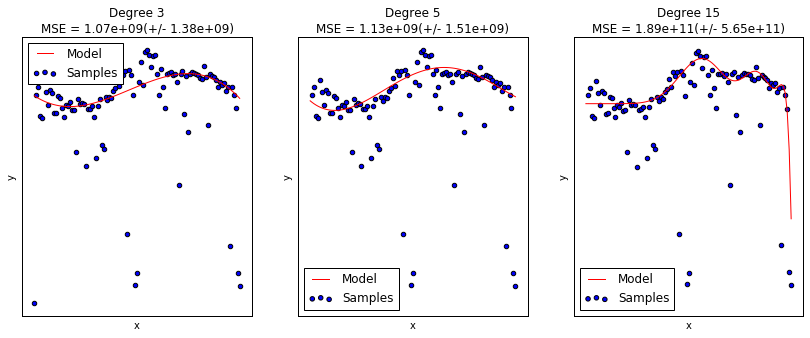

In [167]:
# Polynomial ＋ Robust

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

# np.random.seed(0)
# n_samples = 30
degrees = [3, 5, 15]

# true_fun = lambda X: np.cos(1.5 * np.pi * X)
# X = np.sort(np.random.rand(n_samples))
# y = true_fun(X) + np.random.randn(n_samples) * 0.1

# Train Data
y=weekly_data['#_of_parking'].values
X=np.arange(0,len(y))
# X=X.reshape((105,1))
# line_X = np.arange(0, 105)


# Test Data
y_test=weekly_data_test['#_of_parking'].values
X_test=np.arange(0,len(y_test))
# X_test=X_test.reshape((len(X_test,1))


#---------- Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
# model_ransac.fit(X, y)
# line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])
# inlier_mask = model_ransac.inlier_mask_
# outlier_mask = np.logical_not(inlier_mask)



plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    
#     linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("robust_linear_regression", model_ransac)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_validation.cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="mean_squared_error", cv=10)

#     X_test = np.linspace(0, 1, 100)
#     plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X, pipeline.predict(X[:, np.newaxis]),'-r', label="Model")
#     plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
#     plt.xlim((0, 1))
#     plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

